## Hybrid method: Recursive feature addition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Read Data

In [2]:
data = pd.read_csv('../Kyoto_Train.csv')
data.shape

(124055, 24)

In [4]:
data.head()

,Duration,Source,Destination_bytes,Count,Same_srv_rate,Serror_rate,Srv_serror_rate,Dst_host_count,Dst_host_srv_count,Dst_host_same_port_rate,...,Service_code,Flag_code,IDS_detection_code,Malware_detection_code,Ashula_detection_code,Source_IP_Address_code,Destination_IP_Address_code,Start_Time_code,Protocol_code,Label_code
0,2.863309,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,90847.0,14024.0,25836.0,1.0,0.0
1,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,218531.0,8968.0,45541.0,1.0,0.0
2,0.000000,0,0,0,0.0,0.0,1.00,0,0,0.00,...,6.0,6.0,0.0,0.0,0.0,176665.0,15997.0,59860.0,1.0,0.0
3,0.000000,0,0,0,0.0,0.0,0.67,49,100,0.02,...,6.0,6.0,0.0,0.0,0.0,52769.0,473.0,40649.0,1.0,0.0
4,0.000000,0,0,1,1.0,0.0,0.36,0,2,0.00,...,6.0,0.0,0.0,0.0,0.0,65048.0,16609.0,39283.0,1.0,0.0


### Train - Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Label_code'], axis=1),
    data['Label_code'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((99244, 23), (24811, 23))

### Remove constant and quasi-constant features

In [6]:
# to speed things up we remove constant, quasi-constand and duplicated features
quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float64(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((99244, 21), (24811, 21))

### Remove duplicated

In [7]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20


0

In [8]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((99244, 21), (24811, 21))

### Train a ML model with all features

In [9]:
# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)
model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.999383


### Rank features by importance

Text(0.5, 0, 'Feature')

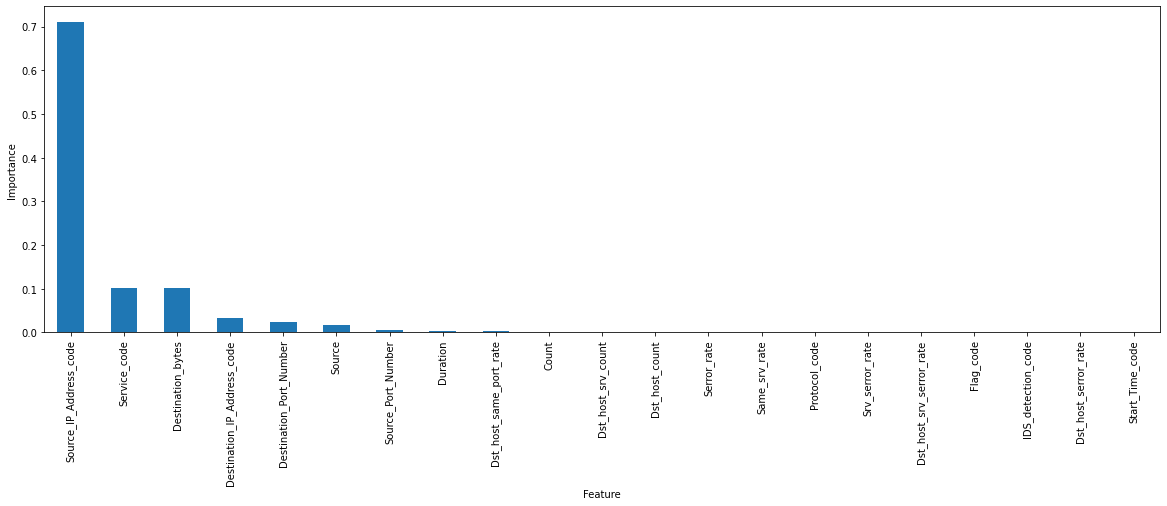

In [10]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.ylabel('Importance')
plt.xlabel('Feature')

In [11]:
# make list of ordered features
features = list(features.index)
features

['Source_IP_Address_code',
 'Service_code',
 'Destination_bytes',
 'Destination_IP_Address_code',
 'Destination_Port_Number',
 'Source',
 'Source_Port_Number',
 'Duration',
 'Dst_host_same_port_rate',
 'Count',
 'Dst_host_srv_count',
 'Dst_host_count',
 'Serror_rate',
 'Same_srv_rate',
 'Protocol_code',
 'Srv_serror_rate',
 'Dst_host_srv_serror_rate',
 'Flag_code',
 'IDS_detection_code',
 'Dst_host_serror_rate',
 'Start_Time_code']

### Build a ML model with 1 feature

In [12]:
# next, we need to build a machine learning
# algorithm using only the most important feature

# build initial model using all the features
model_one_feature = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]

roc_first = roc_auc_score(y_test, y_pred_test)

print('Test one feature xgb ROC AUC=%f' % (roc_first))

Test one feature xgb ROC AUC=0.966363


### Select features

In [13]:
# first we arbitrarily set the increase in roc-auc if the increase is above this threshold,
# the feature will be kept
tol = 0.0001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know which feature is being evaluated
count = 1

# now we loop over all the features, in order of importance:
# remember that features in the list are ordered
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with one feature
    print('Previous round Test ROC AUC={}'.format((roc_first)))

    # determine the increase in the roc-auc
    diff_roc = roc_int - roc_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        roc_first = roc_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print

# now the loop is finished, we evaluated all the features
print('Done!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  Service_code 1  out of  21
New Test ROC AUC=0.9858128375239561
Previous round Test ROC AUC=0.9663626735994006
Increase in ROC AUC=0.019450163924555453
keep:  Service_code

testing feature:  Destination_bytes 2  out of  21
New Test ROC AUC=0.990097055226741
Previous round Test ROC AUC=0.9858128375239561
Increase in ROC AUC=0.004284217702784865
keep:  Destination_bytes

testing feature:  Destination_IP_Address_code 3  out of  21
New Test ROC AUC=0.9936012546144867
Previous round Test ROC AUC=0.990097055226741
Increase in ROC AUC=0.00350419938774571
keep:  Destination_IP_Address_code

testing feature:  Destination_Port_Number 4  out of  21
New Test ROC AUC=0.9974050359879469
Previous round Test ROC AUC=0.9936012546144867
Increase in ROC AUC=0.003803781373460269
keep:  Destination_Port_Number

testing feature:  Source 5  out of  21
New Test ROC AUC=0.9976887075931196
Previous round Test ROC AUC=0.9974050359879469
Increase in ROC AUC=0.000

In [14]:
features_to_keep

['Source_IP_Address_code',
 'Service_code',
 'Destination_bytes',
 'Destination_IP_Address_code',
 'Destination_Port_Number',
 'Source',
 'Duration',
 'Count',
 'Protocol_code']

In [15]:
# build initial model
model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.999330


Gradient Boosting model built with 8 features shows a similar performance than the one built the full dataset.

In [16]:
X_train = X_train[features_to_keep]
X_test = X_test[features_to_keep]

In [17]:
X_train.shape, X_test.shape

((99244, 9), (24811, 9))

## Standardize Data





In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers





In [19]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation





In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression





In [22]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1).fit(X_train, y_train)

CPU times: user 15.2 ms, sys: 9.9 ms, total: 25.1 ms
Wall time: 1.06 s


In [23]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9025432267945669
F1 Score: 0.002475247524752475
FPR: 0.003826303612742481
TPR: 0.001284796573875803


### Naive Bayes





In [24]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-09).fit(X_train, y_train)

CPU times: user 22.9 ms, sys: 5.01 ms, total: 27.9 ms
Wall time: 26.2 ms


In [25]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.0
FPR: 1.0
TPR: 1.0


### Random Forest





In [26]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 4.15 s, sys: 55.6 ms, total: 4.21 s
Wall time: 4.21 s


In [27]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


### KNN




In [28]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform').fit(X_train, y_train)

CPU times: user 5.42 s, sys: 25.6 ms, total: 5.45 s
Wall time: 5.44 s


In [29]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.9058885171899561
f1: 0.0
fpr: 1.0
tpr: 1.0


### CatBoost




In [30]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6550709	total: 64.3ms	remaining: 3.15s
1:	learn: 0.6204908	total: 71.4ms	remaining: 1.71s
2:	learn: 0.5879896	total: 79.4ms	remaining: 1.24s
3:	learn: 0.5574233	total: 86.4ms	remaining: 993ms
4:	learn: 0.5295602	total: 93.6ms	remaining: 842ms
5:	learn: 0.5036472	total: 101ms	remaining: 744ms
6:	learn: 0.4796855	total: 108ms	remaining: 666ms
7:	learn: 0.4566135	total: 116ms	remaining: 607ms
8:	learn: 0.4353835	total: 122ms	remaining: 556ms
9:	learn: 0.4150361	total: 129ms	remaining: 515ms
10:	learn: 0.3958984	total: 135ms	remaining: 480ms
11:	learn: 0.3788366	total: 142ms	remaining: 451ms
12:	learn: 0.3617713	total: 149ms	remaining: 425ms
13:	learn: 0.3460650	total: 156ms	remaining: 402ms
14:	learn: 0.3306402	total: 163ms	remaining: 381ms
15:	learn: 0.3162497	total: 171ms	remaining: 363ms
16:	learn: 0.3029058	total: 179ms	remaining: 348ms
17:	learn: 0.2899568	total: 186ms	remaining: 331ms
18:	learn: 0.2776763	total: 193ms	remaining: 315ms
19:	learn: 0.2665417	total: 201ms	re

In [31]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
FPR: 1.0
TPR: 1.0


## Model Evaluation





In [32]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../Kyoto_Test.csv")
test_df.shape

(62028, 24)

In [33]:
# Create feature matrix X and target vextor y
y_eval = test_df['Label_code']
X_eval = test_df.drop(columns=['Label_code'])

In [34]:
X_eval = X_eval[features_to_keep]

In [35]:
X_eval.shape

(62028, 9)

### Model Evaluation - Logistic Regression





In [36]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=42)

In [37]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [38]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.90537463221958
Testing accuracy is  0.9025432267945669


In [39]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.9025432267945669
F1 Score: 0.002475247524752475
Precision Score: 0.033707865168539325
Recall Score: 0.001284796573875803
Confusion Matrix:
 [[22390    86]
 [ 2332     3]]


### Cross validation - Logistic Regression





In [40]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.90333 (+/- 0.00050)
F1 Score: 0.00100 (+/- 0.00305)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.18333 (+/- 0.64031)
Recall: 0.00050 (+/- 0.00153)


### Model Evaluation - Naive Bayes





In [41]:
modelNB = GaussianNB(var_smoothing=1e-05)
modelNB.fit(X_train, y_train)

GaussianNB(var_smoothing=1e-05)

In [42]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [43]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.43815243238885976
Testing accuracy is  0.9058885171899561


In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))



Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - Naive Bayes





In [45]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.42429 (+/- 0.32413)
F1 Score: 0.20515 (+/- 0.13739)
Precision: 0.11642 (+/- 0.07809)
Recall: 0.86441 (+/- 0.57706)


### Model Evaluation - Random Forest




In [46]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [47]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [48]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  1.0
Testing accuracy is  0.9058885171899561


In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - Random Forest





In [50]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99982 (+/- 0.00034)
F1 Score: 0.99908 (+/- 0.00175)
Precision: 0.99950 (+/- 0.00214)
Recall: 0.99866 (+/- 0.00250)


### Model Evaluation - KNN





In [51]:
modelKNN = KNeighborsClassifier(algorithm='auto',leaf_size=1,n_neighbors=2,weights='uniform')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, n_neighbors=2)

In [52]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [53]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9978537745354883
Testing accuracy is  0.9058885171899561


In [54]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.0
Precision Score: 0.0
Recall Score: 0.0
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross validation - KNN




In [55]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99420 (+/- 0.00210)
F1 Score: 0.96940 (+/- 0.01131)
Precision: 0.98584 (+/- 0.00749)
Recall: 0.95355 (+/- 0.01903)


### Model Evaluation - CatBoost




In [56]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6550709	total: 7.63ms	remaining: 374ms
1:	learn: 0.6204908	total: 14.9ms	remaining: 359ms
2:	learn: 0.5879896	total: 22.2ms	remaining: 347ms
3:	learn: 0.5574233	total: 29ms	remaining: 333ms
4:	learn: 0.5295602	total: 36.6ms	remaining: 330ms
5:	learn: 0.5036472	total: 43.3ms	remaining: 318ms
6:	learn: 0.4796855	total: 50.1ms	remaining: 308ms
7:	learn: 0.4566135	total: 57.1ms	remaining: 300ms
8:	learn: 0.4353835	total: 63.4ms	remaining: 289ms
9:	learn: 0.4150361	total: 70ms	remaining: 280ms
10:	learn: 0.3958984	total: 76.8ms	remaining: 272ms
11:	learn: 0.3788366	total: 83.2ms	remaining: 263ms
12:	learn: 0.3617713	total: 90.4ms	remaining: 257ms
13:	learn: 0.3460650	total: 97.1ms	remaining: 250ms
14:	learn: 0.3306402	total: 104ms	remaining: 244ms
15:	learn: 0.3162497	total: 111ms	remaining: 236ms
16:	learn: 0.3029058	total: 117ms	remaining: 228ms
17:	learn: 0.2899568	total: 124ms	remaining: 220ms
18:	learn: 0.2776763	total: 131ms	remaining: 213ms
19:	learn: 0.2665417	total: 137

In [57]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [58]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9970577566401999
Testing accuracy is  0.9058885171899561


In [59]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.9058885171899561
F1 Score: 0.8611563563923045
Precision Score: 0.8206340055766175
Recall Score: 0.9058885171899561
Confusion Matrix:
 [[22476     0]
 [ 2335     0]]


### Cross validation - CatBoost





In [60]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6555133	total: 5.79ms	remaining: 284ms
1:	learn: 0.6211430	total: 11.4ms	remaining: 273ms
2:	learn: 0.5886418	total: 17.4ms	remaining: 272ms
3:	learn: 0.5589226	total: 22.8ms	remaining: 262ms
4:	learn: 0.5312326	total: 28.1ms	remaining: 253ms
5:	learn: 0.5051455	total: 33.4ms	remaining: 245ms
6:	learn: 0.4809291	total: 39ms	remaining: 239ms
7:	learn: 0.4578494	total: 44.3ms	remaining: 233ms
8:	learn: 0.4369799	total: 49.7ms	remaining: 226ms
9:	learn: 0.4167505	total: 55.3ms	remaining: 221ms
10:	learn: 0.3978732	total: 60.5ms	remaining: 215ms
11:	learn: 0.3805048	total: 65.9ms	remaining: 209ms
12:	learn: 0.3640009	total: 71.2ms	remaining: 203ms
13:	learn: 0.3479498	total: 76.8ms	remaining: 198ms
14:	learn: 0.3330211	total: 82.1ms	remaining: 191ms
15:	learn: 0.3183627	total: 87.2ms	remaining: 185ms
16:	learn: 0.3040440	total: 92.5ms	remaining: 180ms
17:	learn: 0.2918566	total: 97.9ms	remaining: 174ms
18:	learn: 0.2795573	total: 103ms	remaining: 169ms
19:	learn: 0.2684350	tota

17:	learn: 0.2917108	total: 96.4ms	remaining: 171ms
18:	learn: 0.2802057	total: 100ms	remaining: 164ms
19:	learn: 0.2683899	total: 106ms	remaining: 158ms
20:	learn: 0.2574752	total: 111ms	remaining: 153ms
21:	learn: 0.2470226	total: 116ms	remaining: 148ms
22:	learn: 0.2362525	total: 121ms	remaining: 142ms
23:	learn: 0.2261106	total: 127ms	remaining: 137ms
24:	learn: 0.2166977	total: 132ms	remaining: 132ms
25:	learn: 0.2079166	total: 138ms	remaining: 127ms
26:	learn: 0.1993937	total: 143ms	remaining: 122ms
27:	learn: 0.1914837	total: 148ms	remaining: 116ms
28:	learn: 0.1839194	total: 153ms	remaining: 111ms
29:	learn: 0.1768785	total: 159ms	remaining: 106ms
30:	learn: 0.1699346	total: 164ms	remaining: 101ms
31:	learn: 0.1634878	total: 170ms	remaining: 95.4ms
32:	learn: 0.1572869	total: 175ms	remaining: 90.3ms
33:	learn: 0.1514344	total: 181ms	remaining: 85.1ms
34:	learn: 0.1457041	total: 186ms	remaining: 79.7ms
35:	learn: 0.1399061	total: 191ms	remaining: 74.4ms
36:	learn: 0.1342826	tota

37:	learn: 0.1288943	total: 201ms	remaining: 63.3ms
38:	learn: 0.1235227	total: 206ms	remaining: 58.1ms
39:	learn: 0.1186815	total: 211ms	remaining: 52.8ms
40:	learn: 0.1140606	total: 217ms	remaining: 47.6ms
41:	learn: 0.1093863	total: 222ms	remaining: 42.3ms
42:	learn: 0.1055638	total: 227ms	remaining: 37ms
43:	learn: 0.1017188	total: 233ms	remaining: 31.7ms
44:	learn: 0.0981012	total: 238ms	remaining: 26.4ms
45:	learn: 0.0945307	total: 243ms	remaining: 21.2ms
46:	learn: 0.0908014	total: 249ms	remaining: 15.9ms
47:	learn: 0.0871386	total: 254ms	remaining: 10.6ms
48:	learn: 0.0843856	total: 259ms	remaining: 5.29ms
49:	learn: 0.0809933	total: 264ms	remaining: 0us
0:	learn: 0.6558226	total: 5.38ms	remaining: 264ms
1:	learn: 0.6214690	total: 10.8ms	remaining: 260ms
2:	learn: 0.5889765	total: 16.1ms	remaining: 252ms
3:	learn: 0.5588444	total: 21.6ms	remaining: 249ms
4:	learn: 0.5311715	total: 27ms	remaining: 243ms
5:	learn: 0.5054391	total: 32.3ms	remaining: 237ms
6:	learn: 0.4815639	total

0:	learn: 0.6555133	total: 5.9ms	remaining: 289ms
1:	learn: 0.6211430	total: 11.2ms	remaining: 268ms
2:	learn: 0.5886418	total: 16.3ms	remaining: 256ms
3:	learn: 0.5589226	total: 21.4ms	remaining: 246ms
4:	learn: 0.5312326	total: 26.5ms	remaining: 239ms
5:	learn: 0.5051455	total: 31.8ms	remaining: 234ms
6:	learn: 0.4809291	total: 37.3ms	remaining: 229ms
7:	learn: 0.4578494	total: 42.9ms	remaining: 225ms
8:	learn: 0.4369799	total: 48.1ms	remaining: 219ms
9:	learn: 0.4167505	total: 53.5ms	remaining: 214ms
10:	learn: 0.3978732	total: 58.7ms	remaining: 208ms
11:	learn: 0.3805048	total: 63.9ms	remaining: 202ms
12:	learn: 0.3640009	total: 69.1ms	remaining: 197ms
13:	learn: 0.3479498	total: 74.2ms	remaining: 191ms
14:	learn: 0.3330211	total: 79.6ms	remaining: 186ms
15:	learn: 0.3183627	total: 84.8ms	remaining: 180ms
16:	learn: 0.3040440	total: 89.9ms	remaining: 175ms
17:	learn: 0.2918566	total: 94.9ms	remaining: 169ms
18:	learn: 0.2795573	total: 100ms	remaining: 163ms
19:	learn: 0.2684350	tot

18:	learn: 0.2802057	total: 98.2ms	remaining: 160ms
19:	learn: 0.2683899	total: 103ms	remaining: 155ms
20:	learn: 0.2574752	total: 109ms	remaining: 150ms
21:	learn: 0.2470226	total: 113ms	remaining: 144ms
22:	learn: 0.2362525	total: 119ms	remaining: 139ms
23:	learn: 0.2261106	total: 124ms	remaining: 134ms
24:	learn: 0.2166977	total: 129ms	remaining: 129ms
25:	learn: 0.2079166	total: 134ms	remaining: 124ms
26:	learn: 0.1993937	total: 139ms	remaining: 119ms
27:	learn: 0.1914837	total: 145ms	remaining: 114ms
28:	learn: 0.1839194	total: 150ms	remaining: 108ms
29:	learn: 0.1768785	total: 155ms	remaining: 103ms
30:	learn: 0.1699346	total: 160ms	remaining: 98.1ms
31:	learn: 0.1634878	total: 165ms	remaining: 92.9ms
32:	learn: 0.1572869	total: 170ms	remaining: 87.8ms
33:	learn: 0.1514344	total: 176ms	remaining: 82.7ms
34:	learn: 0.1457041	total: 181ms	remaining: 77.5ms
35:	learn: 0.1399061	total: 186ms	remaining: 72.4ms
36:	learn: 0.1342826	total: 191ms	remaining: 67.2ms
37:	learn: 0.1287360	to

38:	learn: 0.1235227	total: 203ms	remaining: 57.3ms
39:	learn: 0.1186815	total: 208ms	remaining: 52.1ms
40:	learn: 0.1140606	total: 213ms	remaining: 46.8ms
41:	learn: 0.1093863	total: 218ms	remaining: 41.6ms
42:	learn: 0.1055638	total: 224ms	remaining: 36.4ms
43:	learn: 0.1017188	total: 229ms	remaining: 31.2ms
44:	learn: 0.0981012	total: 235ms	remaining: 26.1ms
45:	learn: 0.0945307	total: 240ms	remaining: 20.9ms
46:	learn: 0.0908014	total: 246ms	remaining: 15.7ms
47:	learn: 0.0871386	total: 251ms	remaining: 10.4ms
48:	learn: 0.0843856	total: 256ms	remaining: 5.22ms
49:	learn: 0.0809933	total: 261ms	remaining: 0us
0:	learn: 0.6558226	total: 5.52ms	remaining: 271ms
1:	learn: 0.6214690	total: 10.9ms	remaining: 261ms
2:	learn: 0.5889765	total: 16.5ms	remaining: 258ms
3:	learn: 0.5588444	total: 22ms	remaining: 253ms
4:	learn: 0.5311715	total: 27.2ms	remaining: 245ms
5:	learn: 0.5054391	total: 32.3ms	remaining: 237ms
6:	learn: 0.4815639	total: 37.6ms	remaining: 231ms
7:	learn: 0.4593836	tota

0:	learn: 0.6555133	total: 5.3ms	remaining: 260ms
1:	learn: 0.6211430	total: 10.7ms	remaining: 257ms
2:	learn: 0.5886418	total: 15.8ms	remaining: 248ms
3:	learn: 0.5589226	total: 20.8ms	remaining: 239ms
4:	learn: 0.5312326	total: 26ms	remaining: 234ms
5:	learn: 0.5051455	total: 31.2ms	remaining: 229ms
6:	learn: 0.4809291	total: 36.7ms	remaining: 226ms
7:	learn: 0.4578494	total: 42ms	remaining: 221ms
8:	learn: 0.4369799	total: 47.3ms	remaining: 215ms
9:	learn: 0.4167505	total: 52.6ms	remaining: 211ms
10:	learn: 0.3978732	total: 57.8ms	remaining: 205ms
11:	learn: 0.3805048	total: 62.8ms	remaining: 199ms
12:	learn: 0.3640009	total: 68.1ms	remaining: 194ms
13:	learn: 0.3479498	total: 73.4ms	remaining: 189ms
14:	learn: 0.3330211	total: 78.7ms	remaining: 184ms
15:	learn: 0.3183627	total: 84.1ms	remaining: 179ms
16:	learn: 0.3040440	total: 89.4ms	remaining: 174ms
17:	learn: 0.2918566	total: 95ms	remaining: 169ms
18:	learn: 0.2795573	total: 100ms	remaining: 163ms
19:	learn: 0.2684350	total: 10

19:	learn: 0.2683899	total: 104ms	remaining: 157ms
20:	learn: 0.2574752	total: 110ms	remaining: 151ms
21:	learn: 0.2470226	total: 115ms	remaining: 146ms
22:	learn: 0.2362525	total: 120ms	remaining: 141ms
23:	learn: 0.2261106	total: 125ms	remaining: 136ms
24:	learn: 0.2166977	total: 131ms	remaining: 131ms
25:	learn: 0.2079166	total: 136ms	remaining: 126ms
26:	learn: 0.1993937	total: 141ms	remaining: 120ms
27:	learn: 0.1914837	total: 147ms	remaining: 115ms
28:	learn: 0.1839194	total: 152ms	remaining: 110ms
29:	learn: 0.1768785	total: 157ms	remaining: 105ms
30:	learn: 0.1699346	total: 162ms	remaining: 99.4ms
31:	learn: 0.1634878	total: 167ms	remaining: 94.2ms
32:	learn: 0.1572869	total: 173ms	remaining: 89ms
33:	learn: 0.1514344	total: 178ms	remaining: 83.8ms
34:	learn: 0.1457041	total: 183ms	remaining: 78.4ms
35:	learn: 0.1399061	total: 188ms	remaining: 73.1ms
36:	learn: 0.1342826	total: 193ms	remaining: 67.8ms
37:	learn: 0.1287360	total: 198ms	remaining: 62.5ms
38:	learn: 0.1233662	tota

38:	learn: 0.1235227	total: 206ms	remaining: 58ms
39:	learn: 0.1186815	total: 211ms	remaining: 52.7ms
40:	learn: 0.1140606	total: 216ms	remaining: 47.4ms
41:	learn: 0.1093863	total: 221ms	remaining: 42.1ms
42:	learn: 0.1055638	total: 226ms	remaining: 36.8ms
43:	learn: 0.1017188	total: 231ms	remaining: 31.5ms
44:	learn: 0.0981012	total: 237ms	remaining: 26.3ms
45:	learn: 0.0945307	total: 242ms	remaining: 21ms
46:	learn: 0.0908014	total: 247ms	remaining: 15.8ms
47:	learn: 0.0871386	total: 253ms	remaining: 10.5ms
48:	learn: 0.0843856	total: 258ms	remaining: 5.26ms
49:	learn: 0.0809933	total: 263ms	remaining: 0us
0:	learn: 0.6558226	total: 5.14ms	remaining: 252ms
1:	learn: 0.6214690	total: 10.9ms	remaining: 262ms
2:	learn: 0.5889765	total: 16.3ms	remaining: 256ms
3:	learn: 0.5588444	total: 21.6ms	remaining: 248ms
4:	learn: 0.5311715	total: 26.9ms	remaining: 242ms
5:	learn: 0.5054391	total: 32.5ms	remaining: 238ms
6:	learn: 0.4815639	total: 37.9ms	remaining: 233ms
7:	learn: 0.4593836	total:

0:	learn: 0.6555133	total: 5.7ms	remaining: 279ms
1:	learn: 0.6211430	total: 10.9ms	remaining: 261ms
2:	learn: 0.5886418	total: 16ms	remaining: 250ms
3:	learn: 0.5589226	total: 21.1ms	remaining: 243ms
4:	learn: 0.5312326	total: 26.5ms	remaining: 238ms
5:	learn: 0.5051455	total: 32.1ms	remaining: 235ms
6:	learn: 0.4809291	total: 37.4ms	remaining: 230ms
7:	learn: 0.4578494	total: 43.1ms	remaining: 226ms
8:	learn: 0.4369799	total: 48.6ms	remaining: 222ms
9:	learn: 0.4167505	total: 53.5ms	remaining: 214ms
10:	learn: 0.3978732	total: 58.6ms	remaining: 208ms
11:	learn: 0.3805048	total: 63.9ms	remaining: 202ms
12:	learn: 0.3640009	total: 69ms	remaining: 196ms
13:	learn: 0.3479498	total: 74ms	remaining: 190ms
14:	learn: 0.3330211	total: 79.3ms	remaining: 185ms
15:	learn: 0.3183627	total: 84.8ms	remaining: 180ms
16:	learn: 0.3040440	total: 90ms	remaining: 175ms
17:	learn: 0.2918566	total: 94.9ms	remaining: 169ms
18:	learn: 0.2795573	total: 101ms	remaining: 165ms
19:	learn: 0.2684350	total: 106m

18:	learn: 0.2802057	total: 97.9ms	remaining: 160ms
19:	learn: 0.2683899	total: 103ms	remaining: 155ms
20:	learn: 0.2574752	total: 108ms	remaining: 149ms
21:	learn: 0.2470226	total: 113ms	remaining: 144ms
22:	learn: 0.2362525	total: 118ms	remaining: 139ms
23:	learn: 0.2261106	total: 123ms	remaining: 134ms
24:	learn: 0.2166977	total: 129ms	remaining: 129ms
25:	learn: 0.2079166	total: 134ms	remaining: 124ms
26:	learn: 0.1993937	total: 139ms	remaining: 118ms
27:	learn: 0.1914837	total: 145ms	remaining: 114ms
28:	learn: 0.1839194	total: 150ms	remaining: 109ms
29:	learn: 0.1768785	total: 155ms	remaining: 103ms
30:	learn: 0.1699346	total: 160ms	remaining: 98.1ms
31:	learn: 0.1634878	total: 165ms	remaining: 93ms
32:	learn: 0.1572869	total: 171ms	remaining: 88ms
33:	learn: 0.1514344	total: 176ms	remaining: 82.7ms
34:	learn: 0.1457041	total: 181ms	remaining: 77.5ms
35:	learn: 0.1399061	total: 186ms	remaining: 72.4ms
36:	learn: 0.1342826	total: 191ms	remaining: 67.3ms
37:	learn: 0.1287360	total:

38:	learn: 0.1235227	total: 207ms	remaining: 58.4ms
39:	learn: 0.1186815	total: 212ms	remaining: 53ms
40:	learn: 0.1140606	total: 217ms	remaining: 47.6ms
41:	learn: 0.1093863	total: 222ms	remaining: 42.3ms
42:	learn: 0.1055638	total: 227ms	remaining: 37ms
43:	learn: 0.1017188	total: 232ms	remaining: 31.7ms
44:	learn: 0.0981012	total: 237ms	remaining: 26.4ms
45:	learn: 0.0945307	total: 243ms	remaining: 21.1ms
46:	learn: 0.0908014	total: 248ms	remaining: 15.8ms
47:	learn: 0.0871386	total: 253ms	remaining: 10.5ms
48:	learn: 0.0843856	total: 259ms	remaining: 5.28ms
49:	learn: 0.0809933	total: 264ms	remaining: 0us
0:	learn: 0.6558226	total: 5.49ms	remaining: 269ms
1:	learn: 0.6214690	total: 11.1ms	remaining: 265ms
2:	learn: 0.5889765	total: 16.3ms	remaining: 256ms
3:	learn: 0.5588444	total: 21.5ms	remaining: 247ms
4:	learn: 0.5311715	total: 26.8ms	remaining: 241ms
5:	learn: 0.5054391	total: 32.1ms	remaining: 235ms
6:	learn: 0.4815639	total: 37.3ms	remaining: 229ms
7:	learn: 0.4593836	total:

In [61]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.99666 (+/- 0.00193)
F1 Score: 0.98241 (+/- 0.01040)
Precision: 0.99793 (+/- 0.00299)
Recall: 0.96742 (+/- 0.02008)
